In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(1000)
# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [3]:
pickle_in = open("/content/drive/MyDrive/CVPR/New/X_train.pickle","rb")
X_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/MyDrive/CVPR/New/Y_train.pickle","rb")
Y_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/MyDrive/CVPR/Processed_Data/X_test.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open("/content/drive/MyDrive/CVPR/Processed_Data/Y_test.pickle","rb")
Y_test = pickle.load(pickle_in)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")
print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_train= (4876, 224, 224, 3) Y_train= (4876,)
X_test= (263, 224, 224, 3) Y_test= (263,)


In [4]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

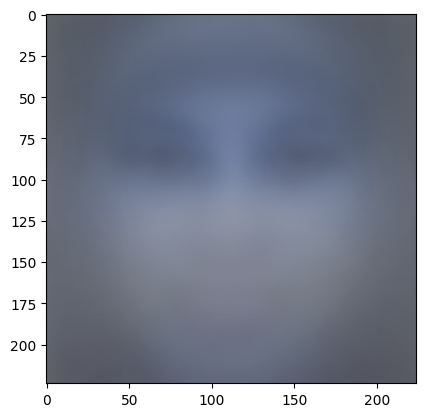

In [5]:
mean_img = np.mean(X_train, axis=0)
plt.imshow(mean_img.astype('uint8'))

In [6]:
pickle_out = open("/content/drive/MyDrive/CVPR/Processed_Data/mean_img.pickle","wb")
pickle.dump(mean_img, pickle_out)
pickle_out.close()

In [7]:
X_train_norm, X_valid_norm, X_test_norm = X_train-mean_img, X_valid-mean_img, X_test-mean_img

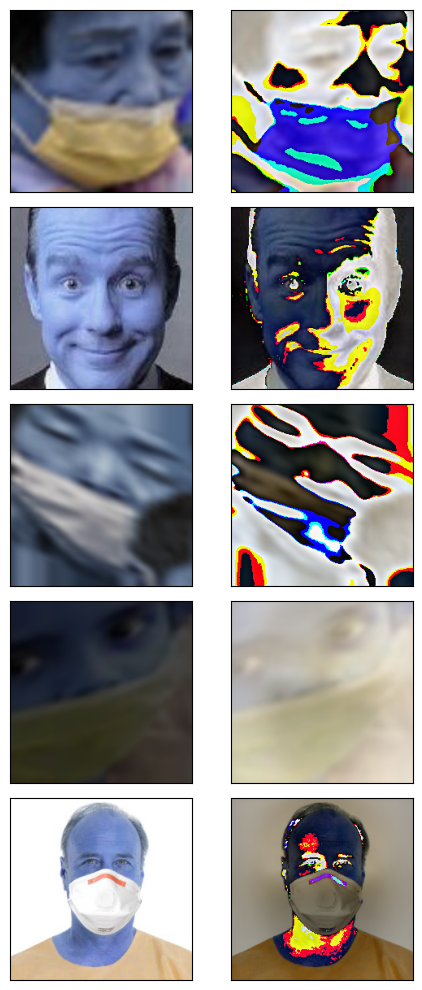

In [8]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2

plt.tight_layout()
plt.show()

In [9]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(3, activation='softmax')
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                        

In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
h = model.fit(x=X_train_norm, y=Y_train, epochs=20, validation_data=(X_valid_norm, Y_valid), batch_size=32)

Epoch 1/20
122/122 [==============================] - 31s 115ms/step - loss: 0.5603 - accuracy: 0.7854 - val_loss: 0.6131 - val_accuracy: 0.7746
Epoch 2/20
122/122 [==============================] - 10s 79ms/step - loss: 0.3083 - accuracy: 0.9000 - val_loss: 0.1933 - val_accuracy: 0.9355
Epoch 3/20
122/122 [==============================] - 10s 82ms/step - loss: 0.2531 - accuracy: 0.9174 - val_loss: 0.2095 - val_accuracy: 0.9385
Epoch 4/20
122/122 [==============================] - 10s 80ms/step - loss: 0.2003 - accuracy: 0.9305 - val_loss: 0.1411 - val_accuracy: 0.9457
Epoch 5/20
122/122 [==============================] - 10s 83ms/step - loss: 0.1765 - accuracy: 0.9400 - val_loss: 0.1054 - val_accuracy: 0.9703
Epoch 6/20
122/122 [==============================] - 9s 77ms/step - loss: 0.1426 - accuracy: 0.9544 - val_loss: 0.0829 - val_accuracy: 0.9713
Epoch 7/20
122/122 [==============================] - 10s 84ms/step - loss: 0.1321 - accuracy: 0.9582 - val_loss: 0.1128 - val_accuracy:

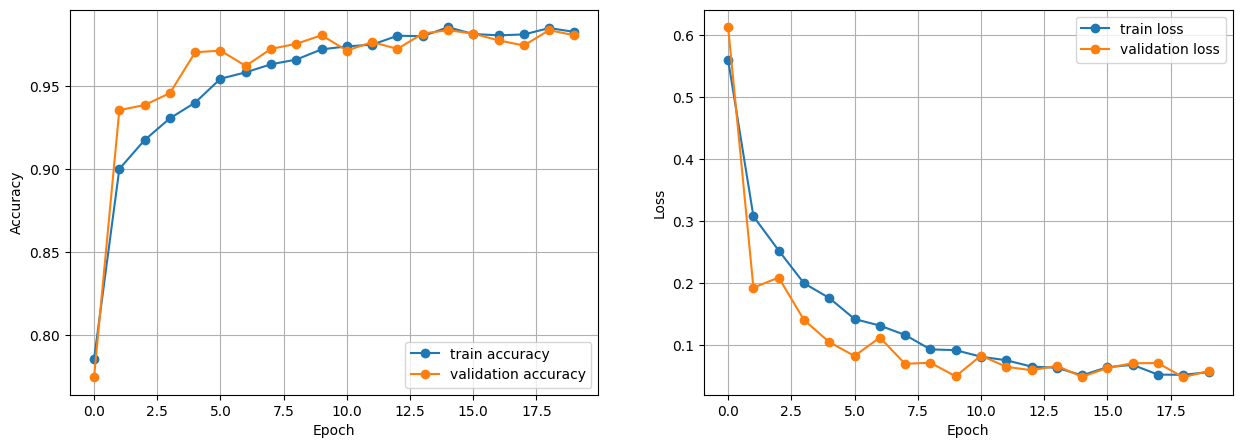

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [13]:
test_loss, test_acc = model.evaluate(X_test_norm, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

9/9 [==============================] - 1s 56ms/step - loss: 0.1351 - accuracy: 0.9582

Test Accuracy: 0.9581748843193054

Test Loss: 0.1350763440132141


1/1 [==============================] - 0s 20ms/step


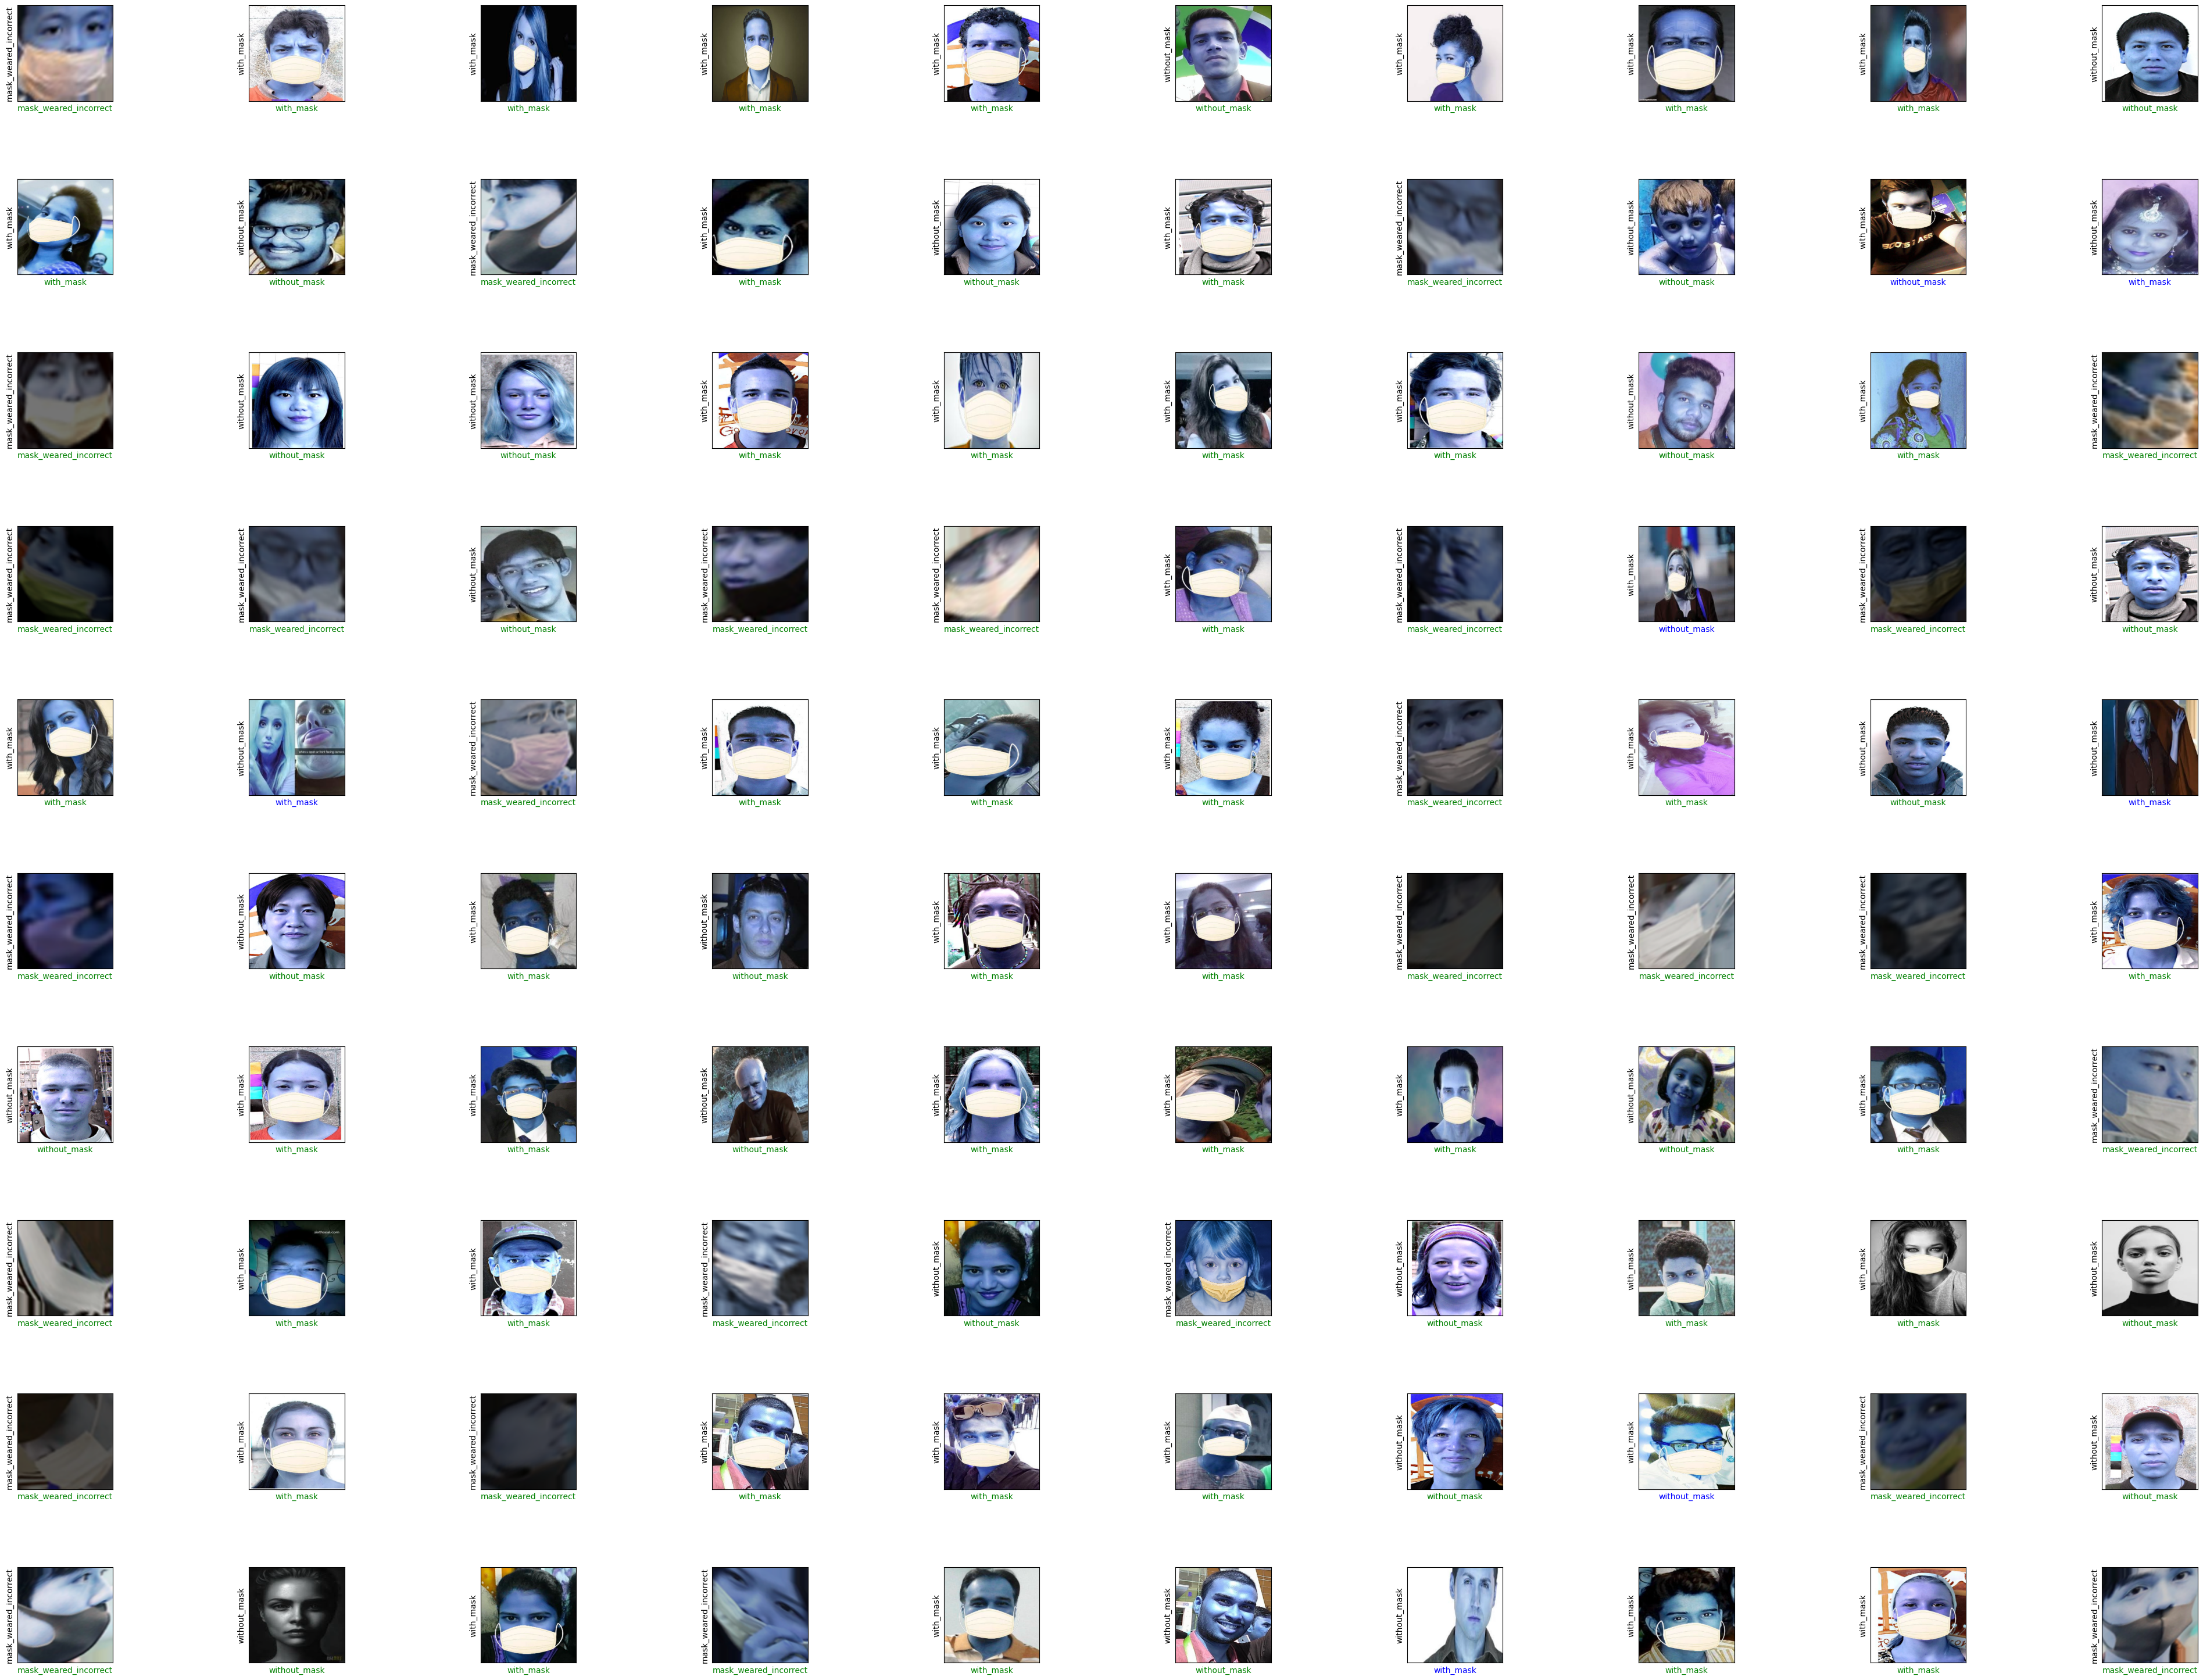

In [14]:
labelz = ("mask_weared_incorrect", "with_mask", "without_mask")
resize = 224
rows = 10
cols = 10
plt.figure(figsize=(40, 30))

for i in range(100):
    plt.subplot(rows, 2 * cols, 2 * i + 1)
    plt.imshow(X_test[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    # Resize and preprocess the image
    image01 = cv2.resize(X_test[i], (resize, resize))
    image01 = image01-mean_img
    image01 = image01.reshape((1, image01.shape[0], image01.shape[1], image01.shape[2]))

    # Make predictions
    predict = model.predict(image01, verbose=1)
    j = predict.argmax(axis=1)[0]

    # Plot labels and predictions
    plt.ylabel(labelz[Y_test[i]])
    if Y_test[i] == j:
        plt.xlabel(labelz[j], color='g')
    else:
        plt.xlabel(labelz[j], color='b')

plt.tight_layout()
plt.show()

In [17]:
model.save('/content/drive/MyDrive/CVPR/Train_Model/modelmaskdetection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
